In [1]:
# !wget https://raw.githubusercontent.com/udacity/nd00333-capstone/master/starter_file/automl.ipynb

# Automated ML

TODO: Import Dependencies. In the cell below, import all the dependencies that you will need to complete the project.

In [2]:
# experiment_name = "ml-experiment-023b" # ids2017" # PLACEHOLDER
experiment_name = "ml-experiment-025" # ids2017" # PLACEHOLDER
run1_id = 'AutoML_532e1f2e-40f2-44cf-845f-4ff45db1a7c8'

csv_data = 'https://workspace1st4305015718.blob.core.windows.net/public/IDS2017-Infilteration.csv'
data_urls = "https://raw.githubusercontent.com/ForesightsIT/IDS/main/IDS2017-Infilteration.zip"
ds_key = "IDS2017Infilteration"
ds_description_text = "IDS2017Infilteration"
source_directory = "./training"
project_folder = source_directory # './training'
script_folder = source_directory

# ws_name = "quick-starts-ws-129448" # !##
workspace_name = "workspace1st" # PLACEHOLDER
subscription_id = "5cf0bb76-4731-4cb5-ac3d-950c07dda6ef" # PLACEHOLDER
resource_group = "group1st" # PLACEHOLDER
workspace_region = "uksouth" #region


In [3]:
## # from azureml.core import Workspace, Datastore, Dataset, Experiment, Environment, Run, ScriptRunConfig, Model
from azureml.telemetry import set_diagnostics_collection
set_diagnostics_collection(send_diagnostics=True)
print("Starting the setup...")
## from sklearn.externals import joblib
# %pip install --upgrade --force-reinstall -r https://aka.ms/automl_linux_requirements.txt
# %pip install --upgrade --force-reinstall -r /anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/automl/core/validated_linux_requirements.txt
# !pip install joblib
# !pip install --upgrade azureml-sdk[notebooks]
# !pip install --user azureml-core
# !pip install azureml-dataprep[parquet] # pyarrow
# %pip install --upgrade --force-reinstall -r https://aka.ms/automl_linux_requirements.txt
import azureml.core
from azureml.core import Workspace, Datastore, Dataset, Experiment, Environment, Run, ScriptRunConfig, Model
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.data.dataset_factory import TabularDatasetFactory
from azureml.core.dataset import Dataset
from azureml.core.datastore import Datastore
from azureml.core.model import Model
from azureml.core.model import InferenceConfig
from azureml.core.webservice import Webservice, AciWebservice, AksWebservice
from azureml.exceptions import ComputeTargetException
from azureml.widgets import RunDetails
from azureml.pipeline.steps import AutoMLStep
import azureml.dataprep as dprep
from azureml.train.automl import AutoMLConfig
from azureml.train.hyperdrive import BanditPolicy, HyperDriveRunConfig, PrimaryMetricGoal, RandomParameterSampling, uniform
from azureml.train.hyperdrive.parameter_expressions import uniform, choice
from azureml.train.hyperdrive.policy import BanditPolicy
from azureml.train.hyperdrive.run import PrimaryMetricGoal
from azureml.train.hyperdrive.runconfig import HyperDriveConfig
from azureml.train.hyperdrive.sampling import RandomParameterSampling
from azureml.train.automl.runtime.automl_explain_utilities import automl_setup_model_explanations
from azureml.interpret import ExplanationClient
from azureml.interpret.mimic_wrapper import MimicWrapper
from azureml.interpret.scoring.scoring_explainer import TreeScoringExplainer
from interpret.ext.glassbox import LGBMExplainableModel
from azureml.train.sklearn import SKLearn
from sklearn import datasets
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from IPython import get_ipython
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
import logging, os, csv, pkg_resources, itertools, shutil, joblib, json, requests, random, sys, time, traceback
print("SDK version:", azureml.core.VERSION)

Turning diagnostics collection on. 
Starting the setup...
SDK version: 1.22.0


In [4]:
ws = Workspace.from_config()
experiment_name = experiment_name
experiment=Experiment(ws, experiment_name)

output = {}
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
Subscription ID,5cf0bb76-4731-4cb5-ac3d-950c07dda6ef
Workspace,workspace1st
Resource Group,group1st
Location,uksouth
Experiment Name,ml-experiment-025


In [5]:
cpu_cluster_name = "cpu-cluster" # "cpu-cluster-1"

try:
    compute_target = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_DS12_V2',min_nodes=1,max_nodes=4,vm_priority='lowpriority')
    compute_target = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


## Dataset

### Overview
TODO: In this markdown cell, give an overview of the dataset you are using. Also mention the task you will be performing.


TODO: Get data. In the cell below, write code to access the data you will be using in this project. Remember that the dataset needs to be external.

In [6]:
## # https://workspace1st4305015718.blob.core.windows.net/public/IDS2017-Infilteration.csv
## # https://www.unb.ca/cic/datasets/ids-2017.html
## # Iman Sharafaldin, Arash Habibi Lashkari, and Ali A. Ghorbani,
## # “Toward Generating a New Intrusion Detection Dataset and Intrusion Traffic Characterization”,
## # 4th International Conference on Information Systems Security and Privacy (ICISSP), Purtogal, January 2018.
## # Try to load the dataset from the Workspace. Otherwise, create it from the file
## # NOTE: update the key to match the dataset name
found = False
key = ds_key # "IDS2017Infilteration"
description_text = ds_description_text # "IDS2017Infilteration"

if key in ws.datasets.keys(): 
        found = True
        dataset = ws.datasets[key] 

if not found:
        # # Create AML Dataset and register it into Workspace
        csv_data = 'https://workspace1st4305015718.blob.core.windows.net/public/IDS2017-Infilteration.csv'

data = csv_data # "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/creditcard.csv"
# dataset = Dataset.Tabular.from_delimited_files(data)

dataset = ws.datasets[key]
training_data, validation_data = dataset.random_split(percentage=0.8, seed=0) # 0.8 # 223

# dataset = Dataset.Tabular.from_delimited_files(data)
# training_data, validation_data = dataset.random_split(percentage=0.8, seed=223)
# !training_data = dataset
# !validation_data = dataset

df = dataset.to_pandas_dataframe()

# label_column_name = ' Label' # 'Class'
label_column_name = df.columns[-1]

df.describe()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,...,Column30,Column31,Column32,Column33,Column34,Column35,Column36,Column37,Column38,Column39
count,288602.00,288602.00,288602.00,288602.00,288602.00,288602.00,288602.00,288602.00,288602.00,288602.00,...,288602.00,288602.00,288602.00,288602.00,288602.00,288602.00,288602.00,288602.00,288602.00,288602.00
mean,3.44,566.11,566.22,6.23,6.23,162.48,162.48,61371.51,6.22,6.22,...,40.73,849457.06,2484256.74,0.23,1071999.65,25.69,362.78,107.55,40.42,0.00
std,49.75,26002.62,26053.50,74.59,74.59,2094.13,2094.13,519510.20,111.40,111.40,...,137.72,3188036.94,10517584.18,0.42,4639822.01,5.85,825.93,229.14,63.63,0.01
min,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,4.00,4.00,2.00,2.00,40.00,40.00,0.00,1.00,1.00,...,0.00,0.00,0.00,0.00,0.00,20.00,6.00,0.00,0.00,0.00
50%,1.00,49.00,49.00,2.00,2.00,48.00,48.00,0.00,2.00,2.00,...,0.00,0.00,0.00,0.00,32.26,24.00,53.00,10.41,6.00,0.00
75%,1.00,95.00,95.00,3.00,3.00,72.00,72.00,0.00,2.00,2.00,...,0.00,32.53,0.00,0.00,27758.71,32.00,145.00,54.22,77.00,0.00
max,9130.00,12870338.00,12900000.00,22673.00,22673.00,742984.00,742984.00,65200000.00,44553.00,44553.00,...,4467.11,81600000.00,120000000.00,1.00,84800000.00,60.00,23360.00,3439.67,1543.00,1.00


In [7]:
df.groupby([label_column_name]).count()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,...,Column29,Column30,Column31,Column32,Column33,Column34,Column35,Column36,Column37,Column38
Column39,,,,,,,,,,,,,,,,,,,,,
0,288566,288566,288566,288566,288566,288566,288566,288566,288566,288566,...,288566,288566,288566,288566,288566,288566,288566,288566,288566,288566
1,36,36,36,36,36,36,36,36,36,36,...,36,36,36,36,36,36,36,36,36,36


In [8]:
# df_sorted = df.sort_values(by=(df.columns[-1]), ascending=False, inplace=True)
# df.loc[73090].to_dict()
# df.dtypes
# columns_to_be_removed = ['Flow Bytes/s', ' Flow Packets/s']
# df = pd.read_csv(csv_data).drop(columns_to_be_removed, axis = 'columns') # dataset
# training_data = dataset.drop_columns(columns=['Flow Bytes/s'])
# training_data = dataset.drop_columns(columns=['Flow Bytes/s'])
# df.rename(columns={' Label':'Label'}, inplace=True)
# label = ' Label'
# y_df = x_df.pop(" Label").apply(lambda s: 1 if s == "BENIGN" else 0)

## AutoML Configuration

TODO: Explain why you chose the automl settings and cofiguration you used below.

In [9]:
#"n_cross_validations": 5, # 3
#"enable_stack_ensemble": False
#"experiment_timeout_hours": 0.25,

automl_settings = {
    "experiment_timeout_minutes": 25,
    "max_concurrent_iterations": 5,
    'model_explainability': True,
    "primary_metric": 'accuracy' # 'normalized_root_mean_squared_error' # 'precision_score_weighted, accuracy, AUC_weighted, norm_macro_recall, average_precision_score
}

## # https://aka.ms/AutoMLConfig
# !training_data = dataset # training_data = training_data

automl_config = AutoMLConfig(compute_target=compute_target,
                             task = "classification", # !"regression",
                             training_data = training_data,
                             label_column_name = label_column_name, # 'Column39', # " Label" # 'y'
                             path = project_folder,
                             enable_early_stopping = True,
                             # featurization= 'auto', # Default
                             # enable_onnx_compatible_models=True,
                             debug_log = "automl_errors.log",
                             **automl_settings
                            )


In [10]:
# local_run = experiment.submit(automl_config, show_output = True)
# remote_run = experiment.submit(automl_config, show_output = False)

In [11]:
# run1_id = 'AutoML_532e1f2e-40f2-44cf-845f-4ff45db1a7c8'
from azureml.train.automl.run import AutoMLRun
# local_run = AutoMLRun(experiment = experiment, run_id = 'AutoML_532e1f2e-40f2-44cf-845f-4ff45db1a7c8')
remote_run = AutoMLRun(experiment = experiment, run_id = run1_id)

In [12]:
local_run = remote_run

## Run Details

OPTIONAL: Write about the different models trained and their performance. Why do you think some models did better than others?

TODO: In the cell below, use the `RunDetails` widget to show the different experiments.

In [13]:
remote_run

Experiment,Id,Type,Status,Details Page,Docs Page
ml-experiment-025,AutoML_532e1f2e-40f2-44cf-845f-4ff45db1a7c8,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [14]:
# remote_run.wait_for_completion(show_output=True)

## Results

In [15]:
from azureml.widgets import RunDetails
# RunDetails(local_run).show()
RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 'sd…

## Best Model

TODO: In the cell below, get the best model from the automl experiments and display all the properties of the model.

In [16]:
# best_run, fitted_model = local_run.get_output()
best_run, fitted_model = remote_run.get_output()
print ("The AutoML [Fitted & Later Deployed Best Model] Run ID: ", best_run.id)
print ("The AutoML [Fitted & Later Deployed Best Model] Pipeline Details: ", fitted_model)

The AutoML [Fitted & Later Deployed Best Model] Run ID:  AutoML_532e1f2e-40f2-44cf-845f-4ff45db1a7c8_6
The AutoML [Fitted & Later Deployed Best Model] Pipeline Details:  Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                                 feature_sweeping_config=None,
                                 feature_sweeping_timeout=None,
                                 featurization_config=None, force_text_dnn=None,
                                 is_cross_validation=None,
                                 is_onnx_compatible=None, logger=None,
                                 observer=None, task=None, working_dir=None)),
                ('SparseNormalizer',
                 <azureml.auto...
                                   colsample_bytree=0.5, eta=0.1, gamma=0,
                                   learning_rate=0.1, max_delta_step=0,
                                   max_depth=6, max_leave

In [17]:
best_run_metrics = best_run.get_metrics()

for metric_name in best_run_metrics:
    metric = best_run_metrics[metric_name]
    print(metric_name, metric)

f1_score_macro 1.0
recall_score_micro 1.0
matthews_correlation 1.0
recall_score_macro 1.0
AUC_macro 1.0
AUC_micro 1.0
weighted_accuracy 1.0
average_precision_score_micro 1.0
log_loss 9.3142013956508e-05
recall_score_weighted 1.0
precision_score_macro 1.0
precision_score_weighted 1.0
norm_macro_recall 1.0
f1_score_weighted 1.0
average_precision_score_macro 1.0
balanced_accuracy 1.0
AUC_weighted 1.0
f1_score_micro 1.0
accuracy 1.0
average_precision_score_weighted 1.0
precision_score_micro 1.0
confusion_matrix aml://artifactId/ExperimentRun/dcid.AutoML_532e1f2e-40f2-44cf-845f-4ff45db1a7c8_6/confusion_matrix
accuracy_table aml://artifactId/ExperimentRun/dcid.AutoML_532e1f2e-40f2-44cf-845f-4ff45db1a7c8_6/accuracy_table


## Tests

In [18]:
X_test_df = validation_data.drop_columns(columns=[label_column_name]).to_pandas_dataframe()
y_test_df = validation_data.keep_columns(columns=[label_column_name], validate=True).to_pandas_dataframe()

In [19]:
foresights = fitted_model.predict(X_test_df)
y_pred = foresights
foresights

array([0, 0, 0, ..., 0, 0, 0])

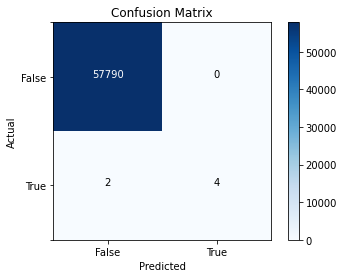

In [20]:
cf =confusion_matrix(y_test_df.values,y_pred)
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
class_labels = ['False','True']
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks,class_labels)
plt.yticks([-0.5,0,1,1.5],['','False','True',''])
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()

In [21]:
client = ExplanationClient.from_run(best_run)
engineered_explanations = client.download_model_explanation(raw=False)
print(engineered_explanations.get_feature_importance_dict())
print("visualize engineered explanations at:-\n" + best_run.get_portal_url())

{'Column34_MeanImputer': 0.001930834715689336, 'Column31_MeanImputer': 0.0016004712910457628, 'Column25_MeanImputer': 0.0015503596330752596, 'Column11_MeanImputer': 0.0014316643013635151, 'Column27_MeanImputer': 0.0013079481133404906, 'Column33_ModeCatImputer_LabelEncoder': 0.000984524598324781, 'Column24_MeanImputer': 0.0009258727275343326, 'Column30_MeanImputer': 0.0008908198683384289, 'Column2_MeanImputer': 0.0008121195631307674, 'Column8_MeanImputer': 0.000763192540828016, 'Column18_MeanImputer': 0.00041049328953073923, 'Column37_MeanImputer': 0.00035066422328958066, 'Column38_MeanImputer': 0.0003464010154202881, 'Column13_MeanImputer': 0.00034391765639867674, 'Column1_MeanImputer': 0.00034146578659666036, 'Column22_MeanImputer': 0.00033102591993447873, 'Column16_MeanImputer': 0.0003109643421694003, 'Column20_ModeCatImputer_LabelEncoder': 0.0003105676434081017, 'Column29_MeanImputer': 0.00028332068420666565, 'Column9_MeanImputer': 0.00023437239304962358, 'Column26_MeanImputer': 0.0

In [22]:
raw_explanations = client.download_model_explanation(raw=True)
print(raw_explanations.get_feature_importance_dict())
print("visualize raw explanations at:-\n" + best_run.get_portal_url())

{'Column34': 0.001930834715689336, 'Column31': 0.0016004712910457628, 'Column25': 0.0015503596330752596, 'Column11': 0.0014316643013635151, 'Column27': 0.0013079481133404906, 'Column33': 0.000984524598324781, 'Column24': 0.0009258727275343326, 'Column30': 0.0008908198683384289, 'Column2': 0.0008121195631307674, 'Column8': 0.000763192540828016, 'Column18': 0.00041049328953073923, 'Column37': 0.00035066422328958066, 'Column38': 0.0003464010154202881, 'Column13': 0.00034391765639867674, 'Column1': 0.00034146578659666036, 'Column22': 0.00033102591993447873, 'Column16': 0.0003109643421694003, 'Column20': 0.0003105676434081017, 'Column29': 0.00028332068420666565, 'Column9': 0.00023437239304962358, 'Column26': 0.00022496295420769644, 'Column17': 0.00022176407847196037, 'Column32': 0.00020475708189379808, 'Column23': 0.00015025192647690651, 'Column14': 0.00014147780811181937, 'Column4': 0.00013918848905748187, 'Column6': 0.0001369301784663768, 'Column36': 0.00012156271223265329, 'Column12': 0.

#### Retrieve AutoML models from training

In [23]:
automl_run, fitted_model = local_run.get_output(metric='accuracy')

In [24]:
X_train = training_data.drop_columns(columns=[label_column_name])
y_train = training_data.keep_columns(columns=[label_column_name], validate=True)
X_test = validation_data.drop_columns(columns=[label_column_name])

In [25]:
automl_explainer_setup_obj = automl_setup_model_explanations(fitted_model, X=X_train, 
                                                             X_test=X_test, y=y_train, 
                                                             task='classification')

Current status: Setting up data for AutoML explanations
Current status: Setting up the AutoML featurizer
Current status: Setting up the AutoML estimator
Current status: Setting up the AutoML featurization for explanations
Current status: Downsampling of evaluation samples from 57796 to 5000 samples
Current status: Generating a feature map for raw feature importance
Current status: Finding all classes from the dataset
Current status: Choosing the surrogate model as LightGBM for the AutoML model
Current status: Data for AutoML explanations successfully setup


In [26]:
explainer = MimicWrapper(ws, automl_explainer_setup_obj.automl_estimator,
                         explainable_model=automl_explainer_setup_obj.surrogate_model, 
                         init_dataset=automl_explainer_setup_obj.X_transform, run=automl_run,
                         features=automl_explainer_setup_obj.engineered_feature_names, 
                         feature_maps=[automl_explainer_setup_obj.feature_map],
                         classes=automl_explainer_setup_obj.classes,
                         explainer_kwargs=automl_explainer_setup_obj.surrogate_model_params)

In [27]:
engineered_explanations = explainer.explain(['local', 'global'], eval_dataset=automl_explainer_setup_obj.X_test_transform)
print(engineered_explanations.get_feature_importance_dict())
print("visualize engineered explanations at:-\n" + automl_run.get_portal_url())

{'Column34_MeanImputer': 0.0022815516509775728, 'Column25_MeanImputer': 0.002277292352679868, 'Column31_MeanImputer': 0.0020840727993623577, 'Column11_MeanImputer': 0.0019527959413398288, 'Column27_MeanImputer': 0.001347104925935313, 'Column33_ModeCatImputer_LabelEncoder': 0.0013288570704532597, 'Column17_MeanImputer': 0.0011902418067074243, 'Column24_MeanImputer': 0.0011019452881430648, 'Column2_MeanImputer': 0.0010014980992606286, 'Column8_MeanImputer': 0.0009406637447700879, 'Column19_MeanImputer': 0.0008988767650911773, 'Column1_MeanImputer': 0.0007521662770045733, 'Column30_MeanImputer': 0.0005556937128679604, 'Column22_MeanImputer': 0.0004072859882396226, 'Column13_MeanImputer': 0.00038804127328247526, 'Column38_MeanImputer': 0.00031859364084806205, 'Column14_MeanImputer': 0.0002984018407072104, 'Column18_MeanImputer': 0.00029808512895897546, 'Column20_ModeCatImputer_LabelEncoder': 0.00028564711859598637, 'Column35_CharGramCountVectorizer_20': 0.00024658634410694517, 'Column36_Me

In [28]:
raw_explanations = explainer.explain(['local', 'global'], get_raw=True,
                                     raw_feature_names=automl_explainer_setup_obj.raw_feature_names,
                                     eval_dataset=automl_explainer_setup_obj.X_test_transform,
                                     raw_eval_dataset=automl_explainer_setup_obj.X_test_raw)
print(raw_explanations.get_feature_importance_dict())
print("visualize raw explanations at:-\n" + automl_run.get_portal_url())

{'Column34': 0.0022815516509775728, 'Column25': 0.002277292352679868, 'Column31': 0.0020840727993623577, 'Column11': 0.0019527959413398288, 'Column27': 0.001347104925935313, 'Column33': 0.0013288570704532597, 'Column17': 0.0011902418067074243, 'Column24': 0.0011019452881430648, 'Column2': 0.0010014980992606286, 'Column8': 0.0009406637447700879, 'Column19': 0.0008988767650911773, 'Column1': 0.0007521662770045733, 'Column30': 0.0005556937128679604, 'Column22': 0.0004072859882396226, 'Column13': 0.00038804127328247526, 'Column38': 0.00031859364084806205, 'Column14': 0.0002984018407072104, 'Column18': 0.00029808512895897546, 'Column20': 0.00028564711859598637, 'Column35': 0.0002567488565211946, 'Column36': 0.00024373305274879504, 'Column26': 0.00023421076629392528, 'Column16': 0.00022423873614673827, 'Column32': 0.00020822022538120795, 'Column9': 0.00019914661938887887, 'Column37': 0.0001933237124907248, 'Column12': 0.00016300310981482807, 'Column4': 0.0001517778979218193, 'Column29': 0.00

## Model Deployment

Remember you have to deploy only one of the two models you trained.. Perform the steps in the rest of this notebook only if you wish to deploy this model.

TODO: In the cell below, register the model, create an inference config and deploy the model as a web service.

In [29]:
original_model = automl_run.register_model(model_name='automl_model', 
                                           model_path='outputs/model.pkl')

In [30]:
# automl_run.download_file(constants.CONDA_ENV_FILE_PATH, 'myenv.yml')
myenv = Environment.from_conda_specification(name="myenv", file_path="myenv.yml")
myenv

{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/intelmpi2018.3-ubuntu16.04:20210104.v1",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "enabled": false,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": "2g"
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "myenv",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
                "anaconda",
                "conda-forge"
      

In [31]:
%%writefile score_025_ids2017inf.py

import urllib.request
import json
import os
import ssl

def allowSelfSignedHttps(allowed):
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

allowSelfSignedHttps(True)

data = {
    "data":
    [
        {
            'Column1': "0",
            'Column2': "0",
            'Column3': "0",
            'Column4': "0",
            'Column5': "0",
            'Column6': "0",
            'Column7': "0",
            'Column8': "0",
            'Column9': "0",
            'Column10': "0",
            'Column11': "0",
            'Column12': "0",
            'Column13': "0",
            'Column14': "0",
            'Column15': "0",
            'Column16': "0",
            'Column17': "0",
            'Column18': "0",
            'Column19': "0",
            'Column20': "0",
            'Column21': "0",
            'Column22': "0",
            'Column23': "0",
            'Column24': "0",
            'Column25': "0",
            'Column26': "0",
            'Column27': "0",
            'Column28': "0",
            'Column29': "0",
            'Column30': "0",
            'Column31': "0",
            'Column32': "0",
            'Column33': "0",
            'Column34': "0",
            'Column35': "0",
            'Column36': "0",
            'Column37': "0",
            'Column38': "0",
        },
    ],
}

body = str.encode(json.dumps(data))

url = 'http://c76e1449-ef84-4a53-9904-61ce2f8aa744.uksouth.azurecontainer.io/score'
api_key = '' # No need for API key for the web service
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}

req = urllib.request.Request(url, body, headers)

try:
    response = urllib.request.urlopen(req)

    result = response.read()
    print(result)
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))

    print(error.info())
    print(json.loads(error.read().decode("utf8", 'ignore')))


Overwriting score_025_ids2017inf.py


In [32]:
%%writefile scoring.py

import urllib.request
import joblib, json, logging, os, pickle, ssl
import numpy as np
import pandas as pd
import azureml.automl.core
from azureml.core.model import Model
from azureml.automl.core.shared import logging_utilities, log_server
from azureml.telemetry import INSTRUMENTATION_KEY
from inference_schema.schema_decorators import input_schema, output_schema
from inference_schema.parameter_types.numpy_parameter_type import NumpyParameterType
from inference_schema.parameter_types.pandas_parameter_type import PandasParameterType

input_sample = pd.DataFrame({"Column1": pd.Series([0], dtype="int64"), "Column2": pd.Series([0], dtype="int64"), "Column3": pd.Series([0], dtype="int64"), "Column4": pd.Series([0], dtype="int64"), "Column5": pd.Series([0], dtype="int64"), "Column6": pd.Series([0], dtype="int64"), "Column7": pd.Series([0], dtype="int64"), "Column8": pd.Series([0.0], dtype="float64"), "Column9": pd.Series([0], dtype="int64"), "Column10": pd.Series([0], dtype="int64"), "Column11": pd.Series([0], dtype="int64"), "Column12": pd.Series([0], dtype="int64"), "Column13": pd.Series([0.0], dtype="float64"), "Column14": pd.Series([0], dtype="int64"), "Column15": pd.Series([0.0], dtype="float64"), "Column16": pd.Series([0], dtype="int64"), "Column17": pd.Series([0], dtype="int64"), "Column18": pd.Series([0], dtype="int64"), "Column19": pd.Series([0], dtype="int64"), "Column20": pd.Series([0], dtype="int64"), "Column21": pd.Series([0], dtype="int64"), "Column22": pd.Series([0], dtype="int64"), "Column23": pd.Series([0], dtype="int64"), "Column24": pd.Series([0], dtype="int64"), "Column25": pd.Series([0.0], dtype="float64"), "Column26": pd.Series([0.0], dtype="float64"), "Column27": pd.Series([0.0], dtype="float64"), "Column28": pd.Series([0.0], dtype="float64"), "Column29": pd.Series([0], dtype="int64"), "Column30": pd.Series([0.0], dtype="float64"), "Column31": pd.Series([0.0], dtype="float64"), "Column32": pd.Series([0], dtype="int64"), "Column33": pd.Series([0], dtype="int64"), "Column34": pd.Series([0.0], dtype="float64"), "Column35": pd.Series([0], dtype="int64"), "Column36": pd.Series([0], dtype="int64"), "Column37": pd.Series([0.0], dtype="float64"), "Column38": pd.Series([0], dtype="int64")})
output_sample = np.array([0])
try:
    log_server.enable_telemetry(INSTRUMENTATION_KEY)
    log_server.set_verbosity('INFO')
    logger = logging.getLogger('azureml.automl.core.scoring_script')
except:
    pass

def init():
    global model
    # This name is model.id of model that we want to deploy deserialize the model file back
    # into a sklearn model
    model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'model.pkl')
    path = os.path.normpath(model_path)
    path_split = path.split(os.sep)
    log_server.update_custom_dimensions({'model_name': path_split[-3], 'model_version': path_split[-2]})
    try:
        logger.info("Loading model from path.")
        model = joblib.load(model_path)
        logger.info("Loading successful.")
    except Exception as e:
        logging_utilities.log_traceback(e, logger)
        raise

@input_schema('data', PandasParameterType(input_sample))
@output_schema(NumpyParameterType(output_sample))
def run(data):
    try:
        result = model.predict(data)
        return json.dumps({"result": result.tolist()})
    except Exception as e:
        result = str(e)
        return json.dumps({"error": result})

Overwriting scoring.py


In [33]:
%%writefile score_025_no_exp.py
import joblib
import pandas as pd
from azureml.core.model import Model

def init():
    global automl_model
    automl_model_path = Model.get_model_path('automl_model')
    automl_model = joblib.load(automl_model_path)

def run(raw_data):
    data = pd.read_json(raw_data, orient='records') 
    predictions = automl_model.predict(data)
    foresights = predictions
    return {'predictions': predictions.tolist()}

Overwriting score_025_no_exp.py


In [34]:
inf_config = InferenceConfig(entry_script='score_025_no_exp.py', environment=myenv)

#### Deploy web service to ACI (Staging)

In [35]:
aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 1, 
                                               tags = {'area': "digits", 'type': "ids_automl_1st"}, 
                                               description = 'service for Automl IDS Classification')


In [36]:
%%time
aci_service_name = 'score025ids2017inf'
print(aci_service_name)
# aci_service = Model.deploy(ws, aci_service_name, [original_model], inf_config, aciconfig) # , overwrite=True
aci_service= AciWebservice(ws, "score025ids2017inf")
# aci_service.wait_for_deployment(True)
print(aci_service.state)

score025ids2017inf
Healthy
CPU times: user 47.4 ms, sys: 0 ns, total: 47.4 ms
Wall time: 563 ms


In [37]:
aci_service.get_logs()

'2021-02-14T21:24:39,188563500+00:00 - gunicorn/run \n2021-02-14T21:24:39,200194000+00:00 - rsyslog/run \n2021-02-14T21:24:39,201888300+00:00 - nginx/run \n/usr/sbin/nginx: /azureml-envs/azureml_7785023fceb74e4facc1b1a577b1faf9/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_7785023fceb74e4facc1b1a577b1faf9/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_7785023fceb74e4facc1b1a577b1faf9/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_7785023fceb74e4facc1b1a577b1faf9/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_7785023fceb74e4facc1b1a577b1faf9/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n2021-02-14T21:24:39,224147300+00:00 - iot-server/run 

In [38]:
web_service_logs = aci_service.get_logs()
with open("./web_service_logs.txt", 'w') as output:
    output.write(str(web_service_logs))
print(web_service_logs)

2021-02-14T21:24:39,188563500+00:00 - gunicorn/run 
2021-02-14T21:24:39,200194000+00:00 - rsyslog/run 
2021-02-14T21:24:39,201888300+00:00 - nginx/run 
/usr/sbin/nginx: /azureml-envs/azureml_7785023fceb74e4facc1b1a577b1faf9/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_7785023fceb74e4facc1b1a577b1faf9/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_7785023fceb74e4facc1b1a577b1faf9/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_7785023fceb74e4facc1b1a577b1faf9/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_7785023fceb74e4facc1b1a577b1faf9/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
2021-02-14T21:24:39,224147300+00:00 - iot-server/run 
rsyslogd

### Pos. Samples:

`df_sorted = df.sort_values(by=(df.columns[-1]), ascending=False, inplace=True)`

`df.head(36)`

`df.head(36).index.tolist()`

`df.loc[73090].to_dict()`


`Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,Column11,Column12,Column13,Column14,Column15,Column16,Column17,Column18,Column19,Column20,Column21,Column22,Column23,Column24,Column25,Column26,Column27,Column28,Column29,Column30,Column31,Column32,Column33,Column34,Column35,Column36,Column37,Column38
0,0,0,15,15,460,460,0,15,15,0,0,0,300,0,513927,513363,0,513925,0,0,5004624,5005212,5004692,233602.73,0,0,0,0,0,233594.23,0,0,241196.38,28,6,3.048003,6`


In [39]:
X_test_json = X_test_df[9:11].to_json(orient='records')
print(X_test_json)
output = aci_service.run(X_test_json)
print('foresights:\n{}\n'.format(output['predictions']))

[{"Column1":11,"Column2":17856,"Column3":17856,"Column4":13,"Column5":13,"Column6":284,"Column7":284,"Column8":0.0,"Column9":9,"Column10":9,"Column11":0,"Column12":0,"Column13":0.0,"Column14":204,"Column15":0.0,"Column16":28508,"Column17":28302,"Column18":0,"Column19":28302,"Column20":0,"Column21":0,"Column22":33195,"Column23":33307,"Column24":33203,"Column25":9964.668,"Column26":0.0,"Column27":1373.5385,"Column28":1373.5385,"Column29":2920,"Column30":1151.352,"Column31":8140.0273,"Column32":0,"Column33":0,"Column34":6194.4062,"Column35":20,"Column36":2920,"Column37":1097.6366,"Column38":0},{"Column1":0,"Column2":6,"Column3":6,"Column4":1,"Column5":1,"Column6":20,"Column7":20,"Column8":0.0,"Column9":1,"Column10":1,"Column11":0,"Column12":0,"Column13":0.0,"Column14":20,"Column15":0.0,"Column16":0,"Column17":41,"Column18":0,"Column19":0,"Column20":0,"Column21":0,"Column22":0,"Column23":41,"Column24":0,"Column25":0.0,"Column26":0.0,"Column27":6.0,"Column28":6.0,"Column29":6,"Column30":0.0

In [40]:
aci_service.update(enable_app_insights=True)

In [41]:
aci_service.scoring_uri

'http://ae33d91f-ccc4-4772-a8e3-990ed9d914ba.uksouth.azurecontainer.io/score'

In [42]:
y_test_df_sorted = y_test_df.sort_values(by=(df.columns[-1]), ascending=False, inplace=True)

In [43]:
y_test_df.head(8)

,Column39
13799,1
16872,1
32082,1
15572,1
17539,1
17219,1
38531,0
38532,0


In [44]:
y_test_df.head(7).index.tolist()

[13799, 16872, 32082, 15572, 17539, 17219, 38531]

In [45]:
df.loc[26841].to_dict()

{'Column1': 0.0,
 'Column2': 0.0,
 'Column3': 0.0,
 'Column4': 1.0,
 'Column5': 1.0,
 'Column6': 32.0,
 'Column7': 32.0,
 'Column8': 0.0,
 'Column9': 1.0,
 'Column10': 1.0,
 'Column11': 0.0,
 'Column12': 0.0,
 'Column13': 0.0,
 'Column14': 32.0,
 'Column15': 0.0,
 'Column16': 0.0,
 'Column17': 51.0,
 'Column18': 0.0,
 'Column19': 0.0,
 'Column20': 0.0,
 'Column21': 0.0,
 'Column22': 0.0,
 'Column23': 51.0,
 'Column24': 0.0,
 'Column25': 0.0,
 'Column26': 0.0,
 'Column27': 0.0,
 'Column28': 0.0,
 'Column29': 0.0,
 'Column30': 0.0,
 'Column31': 0.0,
 'Column32': 0.0,
 'Column33': 1.0,
 'Column34': 0.0,
 'Column35': 32.0,
 'Column36': 0.0,
 'Column37': 0.0,
 'Column38': 0.0,
 'Column39': 0.0}

In [46]:
csv_data = 'https://workspace1st4305015718.blob.core.windows.net/public/IDS2017-Infilteration.csv'
cols = list(pd.read_csv(csv_data, nrows =1))
print(cols)

[' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count', ' URG Flag 

In [47]:
## # train-within-notebook?!!
## https://render.githubusercontent.com/view/ipynb?color_mode=light&commit=475ea361068d237680f8f6127577b39cbeee42cc&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f417a7572652f4d616368696e654c6561726e696e674e6f7465626f6f6b732f343735656133363130363864323337363830663866363132373537376233396362656565343263632f686f772d746f2d7573652d617a7572656d6c2f747261696e696e672f747261696e2d77697468696e2d6e6f7465626f6f6b2f747261696e2d77697468696e2d6e6f7465626f6f6b2e6970796e62&nwo=Azure%2FMachineLearningNotebooks&path=how-to-use-azureml%2Ftraining%2Ftrain-within-notebook%2Ftrain-within-notebook.ipynb&repository_id=145148726&repository_type=Repository#Deploy
service = ws.webservices['score025ids2017inf']
test_samples = X_test_json
test_samples = X_test_df[26840:26842].to_json(orient='records')
result = service.run(input_data = test_samples)
residual = result - y_test_df # y_test
# headers = cols
url = aci_service.scoring_uri # 'http://2f4ed05e-8740-4ddb-935c-e18dafce794d.uksouth.azurecontainer.io/score'
api_key = '' # 'sCqE2ssjRlYgwDRgC1MZxAZgDjP6dwMp' # Replace with the API key for the web service, IF AUTH ENABLED!
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}
resp = requests.post(aci_service.scoring_uri, test_samples, headers = headers)

In [48]:
resp.text

'{"predictions": [0, 0]}'

In [49]:
aci_service.state

'Healthy'

In [50]:
joblib.dump(resp.text, "resp.txt")

['resp.txt']

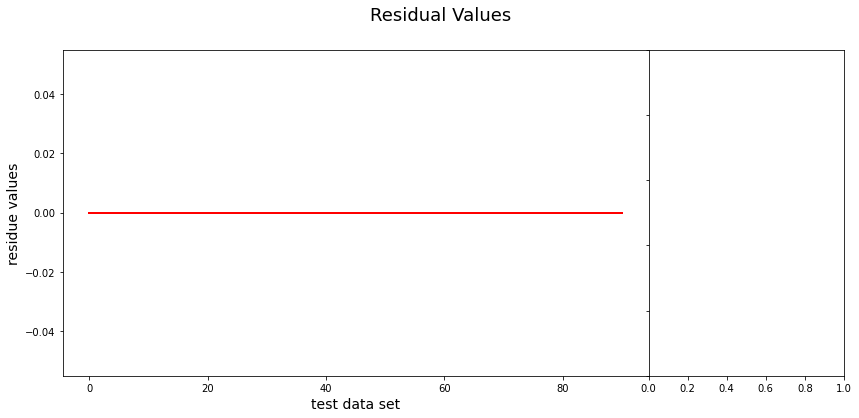

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[3, 1], 'wspace':0, 'hspace': 0})
f.suptitle('Residual Values', fontsize = 18)
f.set_figheight(6)
f.set_figwidth(14)
a0.plot(residual, 'bo', alpha=0.4)
a0.plot([0,90], [0,0], 'r', lw=2)
a0.set_ylabel('residue values', fontsize=14)
a0.set_xlabel('test data set', fontsize=14)
# a1.hist(residual, orientation='horizontal', color='blue', bins=10, histtype='step')
# a1.hist(residual, orientation='horizontal', color='blue', alpha=0.2, bins=10)
a1.set_yticklabels([])
plt.show()

In [52]:
# # TODO: ONNX Exporting
# automl_onnx_model = automl_run.get_output(return_onnx_model=True)
# joblib.dump(automl_onnx_model, "automl_onnx_model.pkl") # !## # !## # !##
# # # automl_onnx_model

In [53]:
%%time
# aci_service.delete()
# print(aci_service.state)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.5 µs


In [54]:
# aks_service.delete()
# aks_target.delete()
# print(aks_service.state)

In [55]:
# # # Deleting AML Compute Cluster via APIs
# # from azureml.core.compute import ComputeTarget, AmlCompute # !1st
# if delete_completion == True:
#     try:
#         cluster_target.delete()
#         print('\n Attemting to delete the ComputeTarget (if found)...')
#         print(cluster_target.status.serialize())
#         cluster_target.wait_for_completion()
#     except Exception as e:
#         if '\n ComputeTarget Not Found!' in e.message:
#             print("\n ComputeTarget has been deleted")
#             delete_completion = False


In [57]:
# !tar -czvf automl-hd-archive.tar.gz .

## Acknowledgements

Apart from the officially provided best practice and patterns' snippets by Microsoft and/or Udacity, this is to acknowledge that such data [subset](https://workspace1st4305015718.blob.core.windows.net/public/IDS2017-Infilteration.csv) was originally made public and is [available online](https://www.unb.ca/cic/datasets/ids-2017.html); while citing the following works: 

Iman Sharafaldin, Arash Habibi Lashkari, and Ali A. Ghorbani,
“Toward Generating a New Intrusion Detection Dataset and Intrusion Traffic Characterization”,
4th International Conference on Information Systems Security and Privacy (ICISSP), Purtogal, January 2018.
